<a href="https://colab.research.google.com/github/Numann-Malik/Project-2/blob/main/CarInsurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Insurance Claim
- Numann Malik

We analyze behavioral data for the customers of a car insurance company (our stakeholder). The goal is to classify what leads a customer to make a policy claim (e.g. for an accident) - this is reflected in the target 'OUTCOME' column. Our stakeholder would want to determine in particular which customers are more accident prone and likely to file a claim, and hence either raise their premiums or consider denying them coverage (so as to maximize their profit).

In [3]:
# !pip install xgboost --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.8 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.5.0
    Uninstalling xgboost-1.5.0:
      Successfully uninstalled xgboost-1.5.0


## Imports

In [5]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, \
GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
plot_confusion_matrix, silhouette_score

# Set global scikit-learn configuration 
from sklearn import set_config
# Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

# Loading and Inspecting Data

In [6]:
filename = 'Car_Insurance_Claim.csv'
df = pd.read_csv(filename)

In [3]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,323164,26-39,female,majority,10-19y,university,upper class,0.582787,1.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,1,0.0
9996,910346,26-39,female,majority,10-19y,none,middle class,0.522231,1.0,after 2015,0.0,1.0,32765,NaN,sedan,1,0,0,0.0
9997,468409,26-39,male,majority,0-9y,high school,middle class,0.470940,1.0,before 2015,0.0,1.0,10238,14000.0,sedan,0,0,0,0.0
9998,903459,26-39,female,majority,10-19y,high school,poverty,0.364185,0.0,before 2015,0.0,1.0,10238,13000.0,sedan,2,0,1,1.0


## Data Cleaning

In [7]:
df = df.drop(['ID'],axis=1)
df.info() # Dropped unnecessary 'ID' column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  10000 non-null  object 
 1   GENDER               10000 non-null  object 
 2   RACE                 10000 non-null  object 
 3   DRIVING_EXPERIENCE   10000 non-null  object 
 4   EDUCATION            10000 non-null  object 
 5   INCOME               10000 non-null  object 
 6   CREDIT_SCORE         9018 non-null   float64
 7   VEHICLE_OWNERSHIP    10000 non-null  float64
 8   VEHICLE_YEAR         10000 non-null  object 
 9   MARRIED              10000 non-null  float64
 10  CHILDREN             10000 non-null  float64
 11  POSTAL_CODE          10000 non-null  int64  
 12  ANNUAL_MILEAGE       9043 non-null   float64
 13  VEHICLE_TYPE         10000 non-null  object 
 14  SPEEDING_VIOLATIONS  10000 non-null  int64  
 15  DUIS                 10000 non-null  

In [8]:
df.duplicated().sum() # 12 duplicate rows

12

In [9]:
df = df.drop_duplicates()
df.duplicated().sum() # Duplicate rows have been dropped

0

In [10]:
df.shape

(9988, 18)

In [11]:
df.isna().sum()
# Out of 9,988 rows there are 970 values missing for 'Credit Score', and 954 values missing for 'Annual Mileage' (both roughly around 10%)
# We will leave them now for EDA purposes, later we will use SimpleImputer when preprocessing for modeling

AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           970
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         954
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

## Univariate Exploratory Visualizations

In [10]:
## functionize a barplot and call it plot_bar

def plot_bar(data,x, y, figsize=(20,5)):
    ## Make a larger fig/ax before plotting
    fig, ax = plt.subplots(figsize=figsize)

    ## Plot barplot
    
    ## counts, counts up the categories, sort the values, then puts them in a 
    ## data frame.
    
    counts = df[x].value_counts().sort_values(ascending=False).to_frame()
    ## ploting the barplot

    sns.barplot(data=counts,x=counts.index, y = counts[x],ax=ax)

    plt.xticks(rotation= 45)
    ax.set_title(f'Categorical Frequencies of {y}', fontsize = 20, fontweight = 'bold');
    ax.set_xlabel(f'Categories for {y}', fontsize = 15, fontweight = 'bold')
    ax.set_ylabel('Counts', fontsize = 15, fontweight = 'bold')

    return fig,ax

0.0    6864
1.0    3124
Name: OUTCOME, dtype: int64


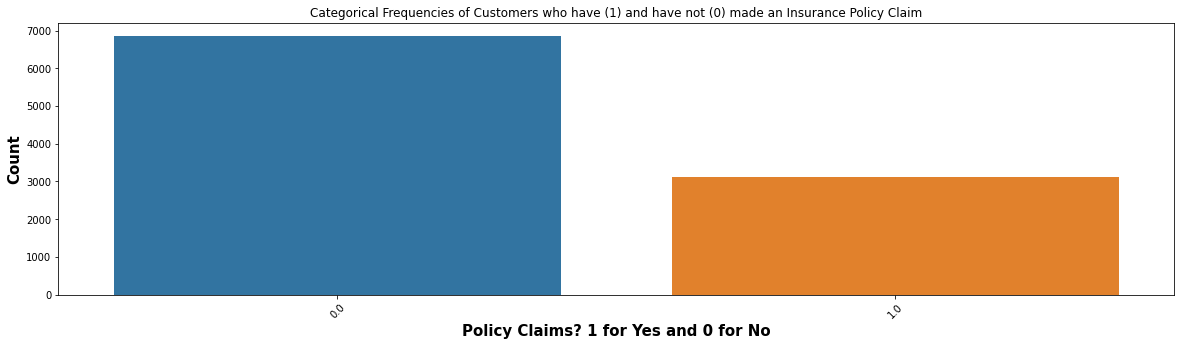

In [11]:
fig, ax = plot_bar(df, 'OUTCOME', 'OUTCOME');
plt.xlabel('Policy Claims? 1 for Yes and 0 for No')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Customers who have (1) and have not (0) made an Insurance Policy Claim');
print(df['OUTCOME'].value_counts())

In [12]:
print(df['OUTCOME'].value_counts(normalize=True))

0.0    0.687225
1.0    0.312775
Name: OUTCOME, dtype: float64


26-39    3062
40-64    2931
16-25    2005
65+      1990
Name: AGE, dtype: int64


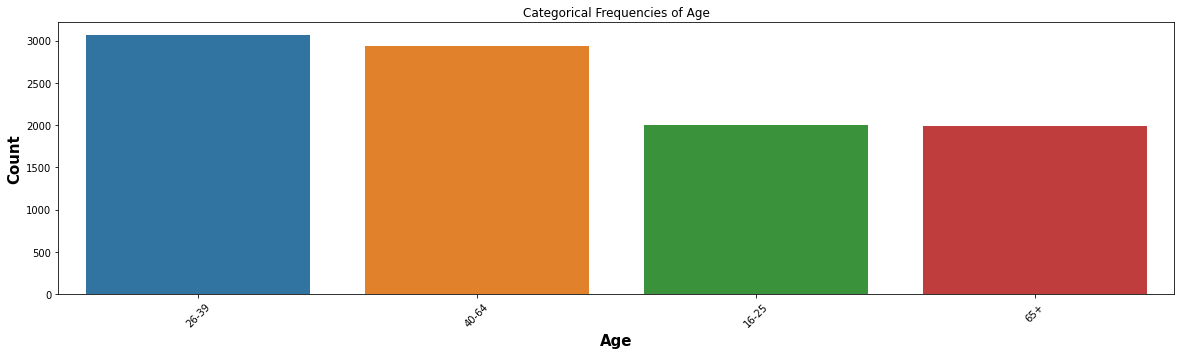

In [13]:
fig, ax = plot_bar(df, 'AGE', 'AGE');
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Age');
print(df['AGE'].value_counts())

In [14]:
print(df['AGE'].value_counts(normalize=True))

26-39    0.306568
40-64    0.293452
16-25    0.200741
65+      0.199239
Name: AGE, dtype: float64


female    5003
male      4985
Name: GENDER, dtype: int64


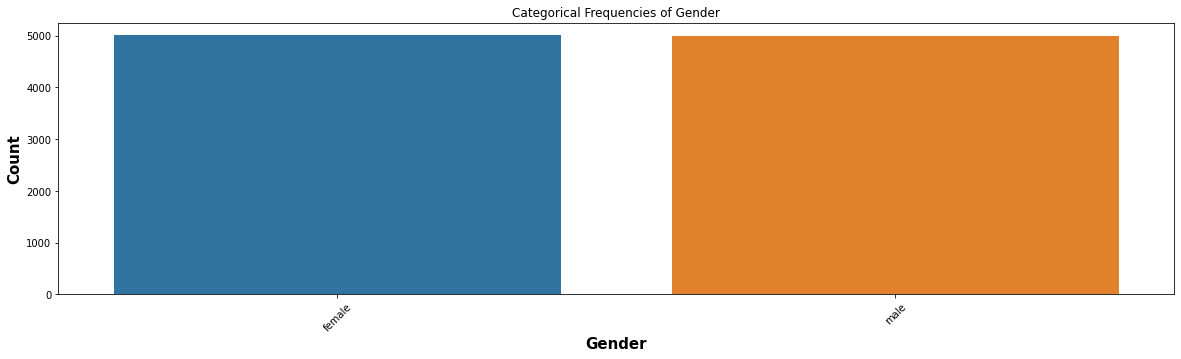

In [15]:
fig, ax = plot_bar(df, 'GENDER', 'GENDER');
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Gender');
print(df['GENDER'].value_counts())

majority    9000
minority     988
Name: RACE, dtype: int64


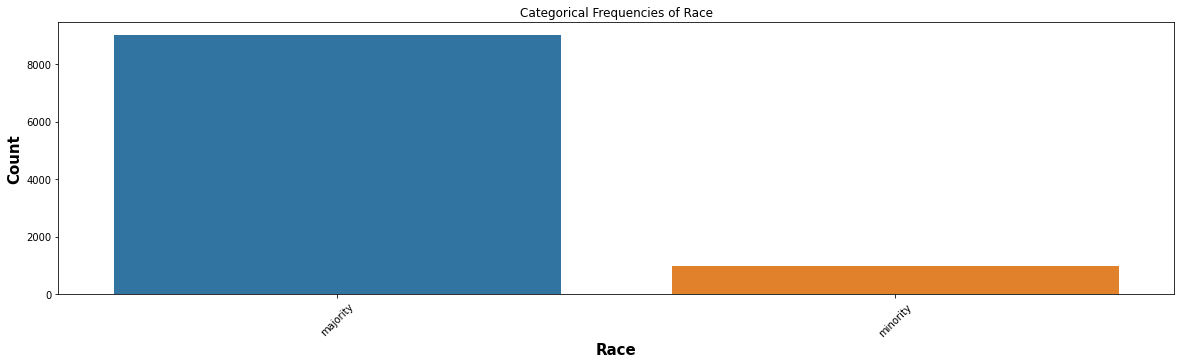

In [16]:
fig, ax = plot_bar(df, 'RACE', 'RACE');
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Race');
print(df['RACE'].value_counts())

0-9y      3519
10-19y    3298
20-29y    2119
30y+      1052
Name: DRIVING_EXPERIENCE, dtype: int64


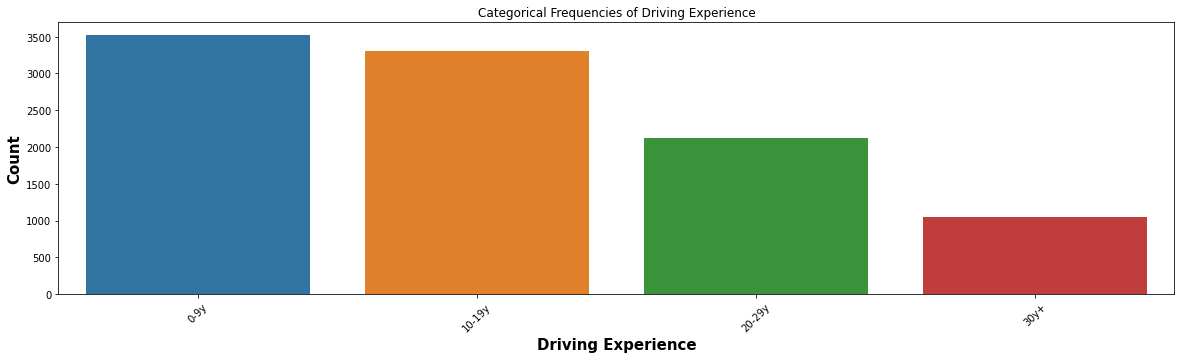

In [17]:
fig, ax = plot_bar(df, 'DRIVING_EXPERIENCE', 'DRIVING_EXPERIENCE');
plt.xlabel('Driving Experience')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Driving Experience');
print(df['DRIVING_EXPERIENCE'].value_counts())

high school    4151
university     3927
none           1910
Name: EDUCATION, dtype: int64


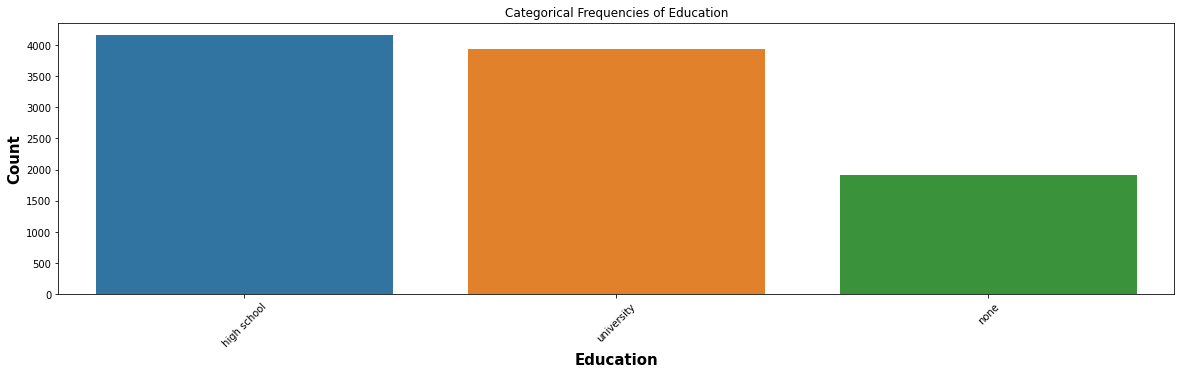

In [18]:
fig, ax = plot_bar(df, 'EDUCATION', 'EDUCATION');
plt.xlabel('Education')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Education');
print(df['EDUCATION'].value_counts())

upper class      4335
middle class     2138
poverty          1804
working class    1711
Name: INCOME, dtype: int64


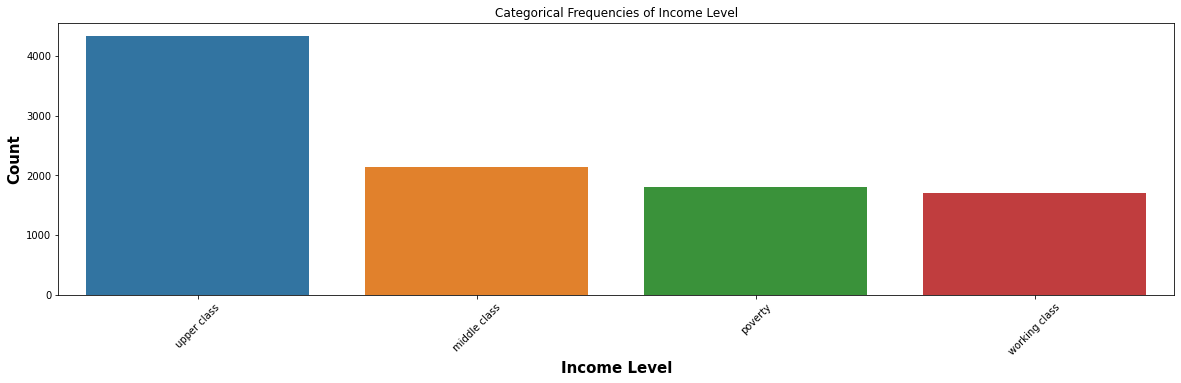

In [19]:
fig, ax = plot_bar(df, 'INCOME', 'INCOME');
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Income Level');
print(df['INCOME'].value_counts())

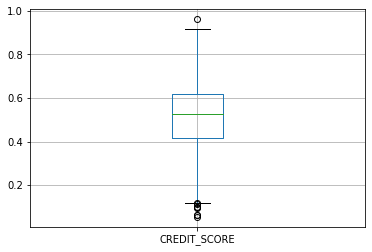

In [20]:
boxplot = df.boxplot(column=['CREDIT_SCORE'])

In [21]:
df['CREDIT_SCORE'].describe() # Summary Statistics for (Scaled) Credit Score

count    9018.000000
mean        0.515813
std         0.137688
min         0.053358
25%         0.417191
50%         0.525033
75%         0.618312
max         0.960819
Name: CREDIT_SCORE, dtype: float64

We identify the credit score outliers below:

In [22]:
#create a function to find outliers using IQR

def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

In [23]:
outliers = find_outliers_IQR(df['CREDIT_SCORE'])

print(f'Number of outliers:' + str(len(outliers)))

print(f'Maximum outlier value:' + str(outliers.max()))

print(f'Minimum outlier value:' + str(outliers.min()))

outliers

Number of outliers:9
Maximum outlier value:0.9608188278116948
Minimum outlier value:0.0533575454627435


2152    0.053358
4955    0.064810
6031    0.060867
6752    0.099655
7784    0.112631
8039    0.095387
8057    0.960819
8194    0.097211
9648    0.115402
Name: CREDIT_SCORE, dtype: float64

Roughly 30% of customers do not own their vehicle, so we assume that they are insuring leased vehicles.

1.0    6967
0.0    3021
Name: VEHICLE_OWNERSHIP, dtype: int64


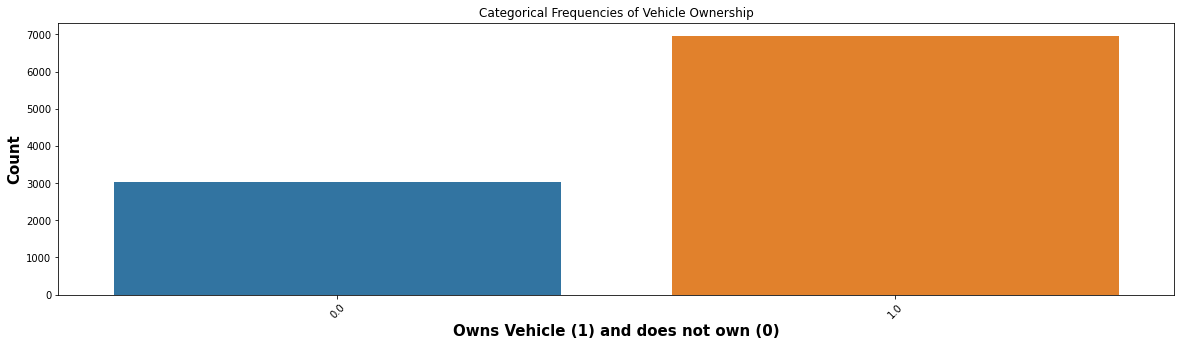

In [24]:
fig, ax = plot_bar(df, 'VEHICLE_OWNERSHIP', 'VEHICLE_OWNERSHIP');
plt.xlabel('Owns Vehicle (1) and does not own (0)')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Vehicle Ownership');
print(df['VEHICLE_OWNERSHIP'].value_counts())

In [25]:
print(df['VEHICLE_OWNERSHIP'].value_counts(normalize=True))

1.0    0.697537
0.0    0.302463
Name: VEHICLE_OWNERSHIP, dtype: float64


before 2015    6955
after 2015     3033
Name: VEHICLE_YEAR, dtype: int64


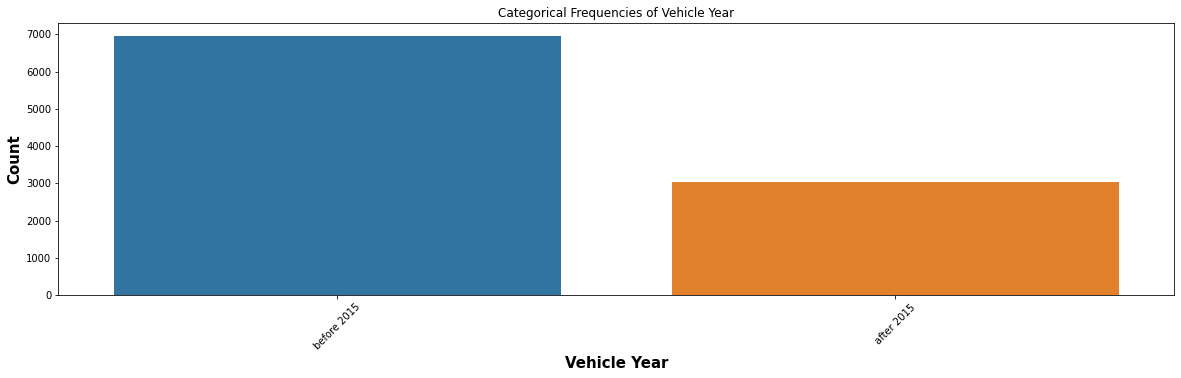

In [26]:
fig, ax = plot_bar(df, 'VEHICLE_YEAR', 'VEHICLE_YEAR');
plt.xlabel('Vehicle Year')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Vehicle Year');
print(df['VEHICLE_YEAR'].value_counts())

0.0    5007
1.0    4981
Name: MARRIED, dtype: int64


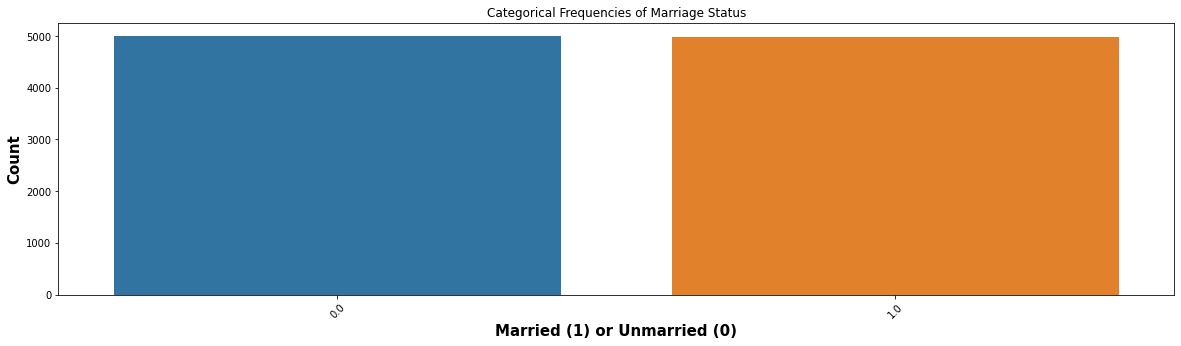

In [27]:
fig, ax = plot_bar(df, 'MARRIED', 'MARRIED');
plt.xlabel('Married (1) or Unmarried (0)')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Marriage Status');
print(df['MARRIED'].value_counts())

1.0    6885
0.0    3103
Name: CHILDREN, dtype: int64


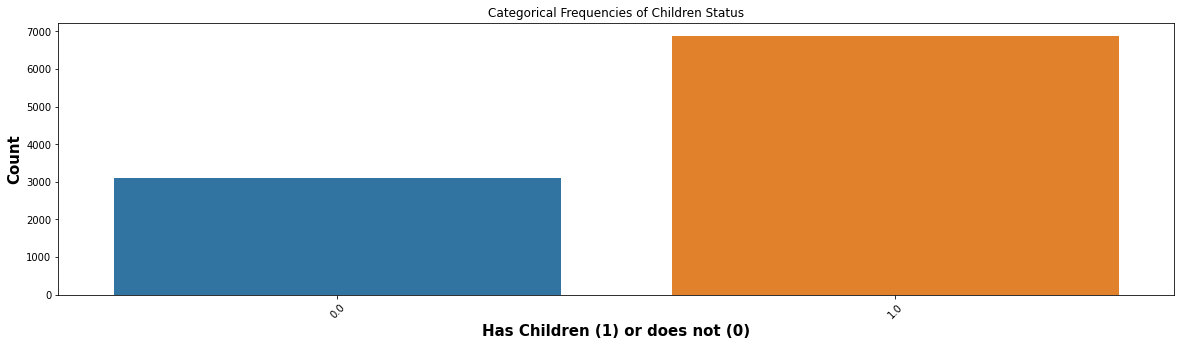

In [28]:
fig, ax = plot_bar(df, 'CHILDREN', 'CHILDREN');
plt.xlabel('Has Children (1) or does not (0)')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Children Status');
print(df['CHILDREN'].value_counts())

10238    6929
32765    2455
92101     484
21217     120
Name: POSTAL_CODE, dtype: int64


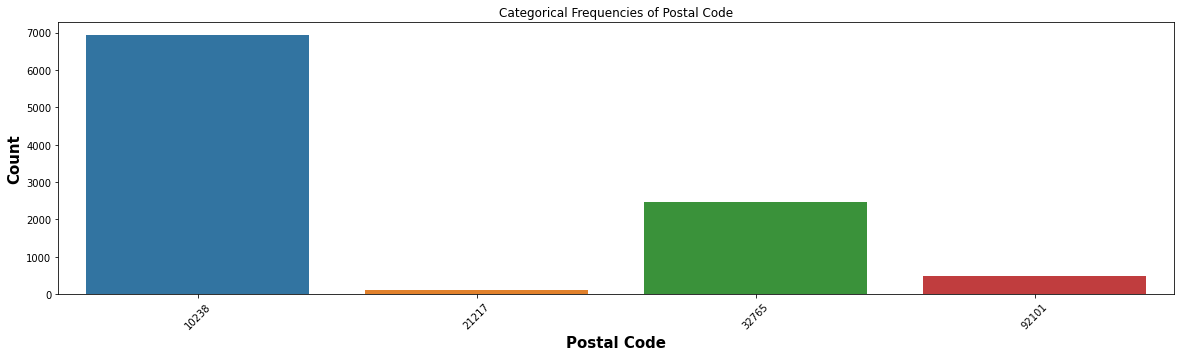

In [29]:
fig, ax = plot_bar(df, 'POSTAL_CODE', 'POSTAL_CODE');
plt.xlabel('Postal Code')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Postal Code');
print(df['POSTAL_CODE'].value_counts())

11000.0    1253
12000.0    1218
13000.0    1136
10000.0    1071
14000.0     891
9000.0      855
15000.0     630
8000.0      557
16000.0     418
7000.0      322
17000.0     245
6000.0      165
18000.0     103
5000.0       65
19000.0      48
4000.0       27
20000.0      13
3000.0       10
21000.0       3
2000.0        2
22000.0       2
Name: ANNUAL_MILEAGE, dtype: int64


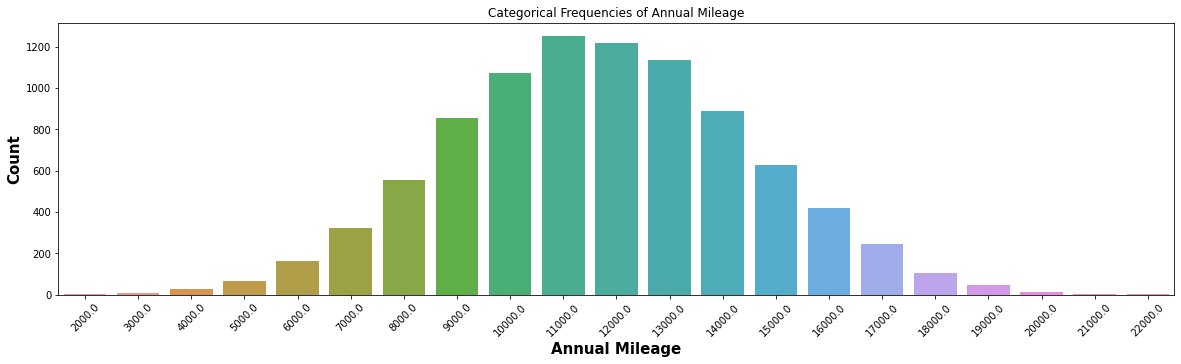

In [30]:
fig, ax = plot_bar(df, 'ANNUAL_MILEAGE', 'ANNUAL_MILEAGE');
plt.xlabel('Annual Mileage')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Annual Mileage');
print(df['ANNUAL_MILEAGE'].value_counts())

sedan         9511
sports car     477
Name: VEHICLE_TYPE, dtype: int64


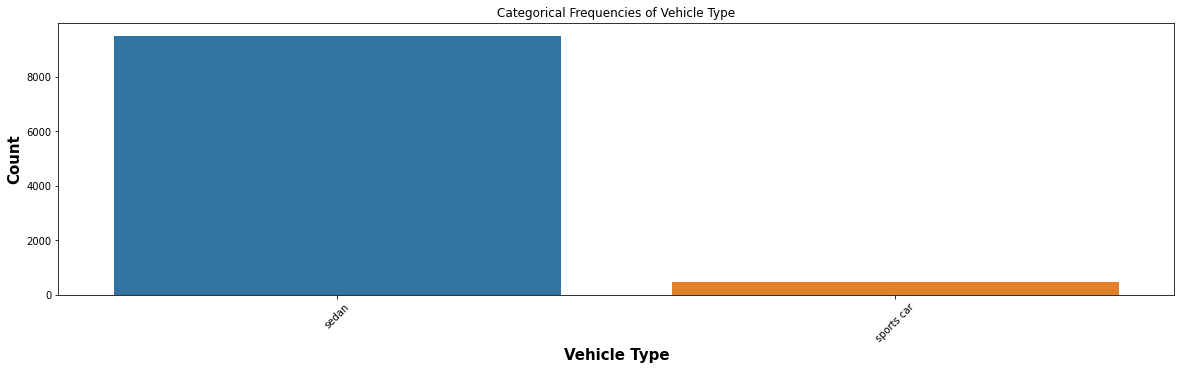

In [31]:
fig, ax = plot_bar(df, 'VEHICLE_TYPE', 'VEHICLE_TYPE');
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Vehicle Type');
print(df['VEHICLE_TYPE'].value_counts())

Almost half of customers have at least 1 speeding violation:

0     5017
1     1543
2     1161
3      830
4      530
5      319
6      188
7      140
8       75
10      50
9       49
11      30
12      20
13      12
15       8
14       5
16       4
17       3
19       2
18       1
22       1
Name: SPEEDING_VIOLATIONS, dtype: int64


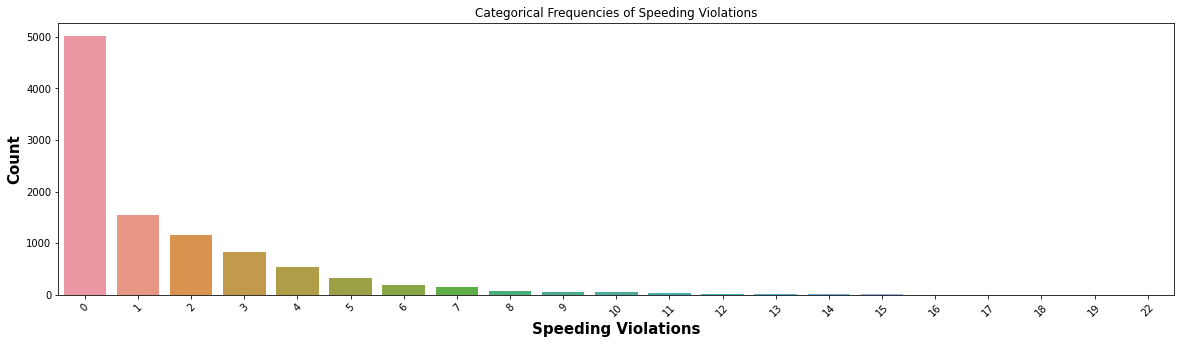

In [32]:
fig, ax = plot_bar(df, 'SPEEDING_VIOLATIONS', 'SPEEDING_VIOLATIONS');
plt.xlabel('Speeding Violations')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Speeding Violations');
print(df['SPEEDING_VIOLATIONS'].value_counts())

0    8106
1    1470
2     331
3      68
4      10
5       2
6       1
Name: DUIS, dtype: int64


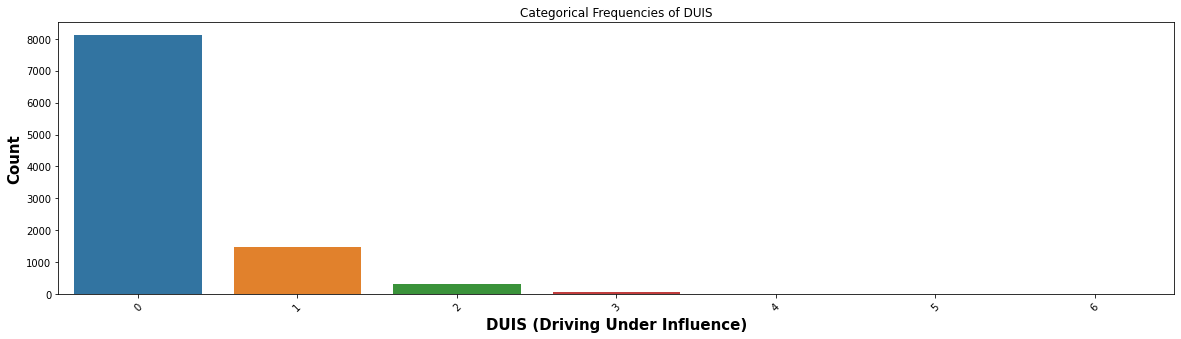

In [33]:
fig, ax = plot_bar(df, 'DUIS', 'DUIS');
plt.xlabel('DUIS (Driving Under Influence)')
plt.ylabel('Count')
plt.title('Categorical Frequencies of DUIS');
print(df['DUIS'].value_counts())

0     5573
1     1783
2     1103
3      646
4      366
5      232
6      144
7       61
8       41
9       19
10       9
11       7
12       2
14       1
15       1
Name: PAST_ACCIDENTS, dtype: int64


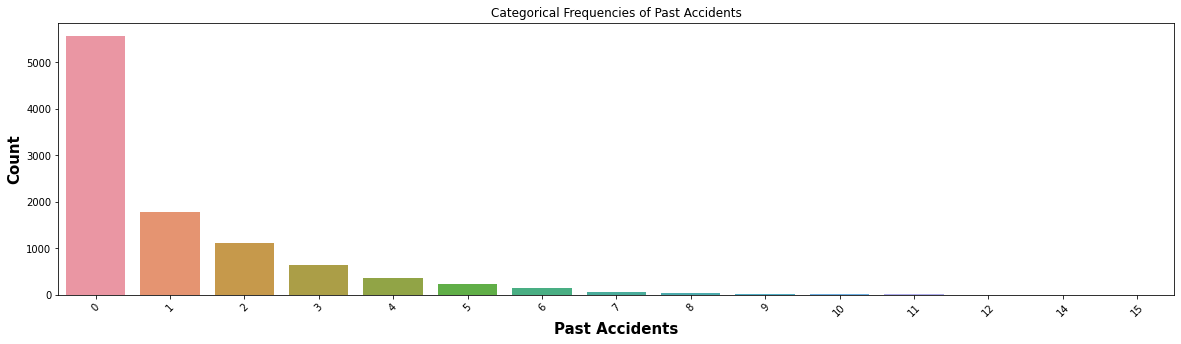

In [34]:
fig, ax = plot_bar(df, 'PAST_ACCIDENTS', 'PAST_ACCIDENTS');
plt.xlabel('Past Accidents')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Past Accidents');
print(df['PAST_ACCIDENTS'].value_counts())

## Multivariate Exploratory Visualizations

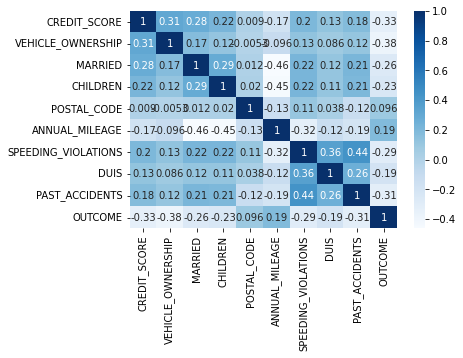

In [35]:
sns.heatmap(df.corr(),annot=True,cmap='Blues'); # Very little correlation between any of the features.

The highest (negative) correlation with target 'Outcome' is 'Vehicle Ownership'. Overall, the highest (again negative) correlation between any two features is between 'Married' and 'Annual Mileage', i.e. customers who are married tend to drive less than those who aren't.

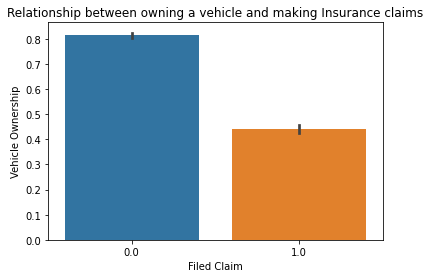

In [36]:
sns.barplot(data=df, y='VEHICLE_OWNERSHIP', x='OUTCOME')
plt.title('Relationship between owning a vehicle and making Insurance claims')
plt.ylabel('Vehicle Ownership')
plt.xlabel('Filed Claim')
plt.show() # First Presentation Plot

Above we see that over 80% of customers who have never made a policy claim owned their vehicle, while less than half have made a policy claim - supporting a conclusion that those who lease their vehicles are more likely to file policy claims with their insurance company.

Text(0.5, 1.0, 'Scatter Plot between Past Accidents and Speeding Violations')

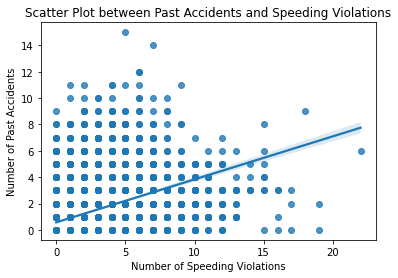

In [37]:
# Scatter Plot with a regression line showing the trend
sns.regplot(x = 'SPEEDING_VIOLATIONS', y= 'PAST_ACCIDENTS',data=df);
plt.xlabel('Number of Speeding Violations')
plt.ylabel('Number of Past Accidents')
plt.title('Scatter Plot between Past Accidents and Speeding Violations')
# Second Presentation Plot

A decent predictor of accidents is the number of speeding violations.

Below are other visualizations analyzing other customer behavior.

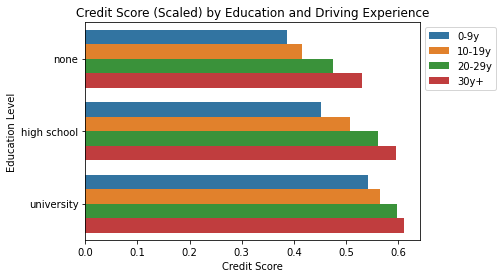

In [38]:
EDE = df.groupby(['EDUCATION', 'DRIVING_EXPERIENCE']).mean().reset_index()
EDE = EDE.sort_values(by='CREDIT_SCORE')
sns.barplot(data=EDE, x='CREDIT_SCORE', y='EDUCATION', hue='DRIVING_EXPERIENCE')
plt.title('Credit Score (Scaled) by Education and Driving Experience')
plt.xlabel('Credit Score')
plt.ylabel('Education Level')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Above we see that with more driving experience, credit scores increase on average, correlating with higher education levels.

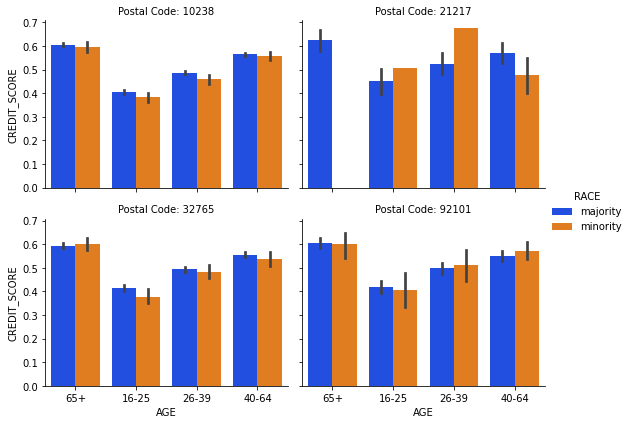

In [39]:
CP = sns.catplot(
        x='AGE', 
        y='CREDIT_SCORE', 
        data=df,
        palette='bright',
        height=3, aspect=1.3,
        kind='bar',
        hue='RACE', 
        col ='POSTAL_CODE',
        col_wrap=2)
CP.set_titles(
    'Postal Code: {col_name}');

Postal Code 21217 stands out with no minorities that are at least 65 years old, and the minority race has the highest credit score on average within the 26-39 age bracket.

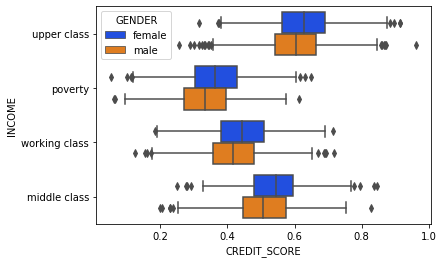

In [40]:
sns.boxplot(
    x='CREDIT_SCORE', 
    y='INCOME', 
    data=df,
    palette='bright',
    hue='GENDER');


We see above that higher credit scores generally correlate with higher income levels. Also, females have higher credit scores than males do on average.

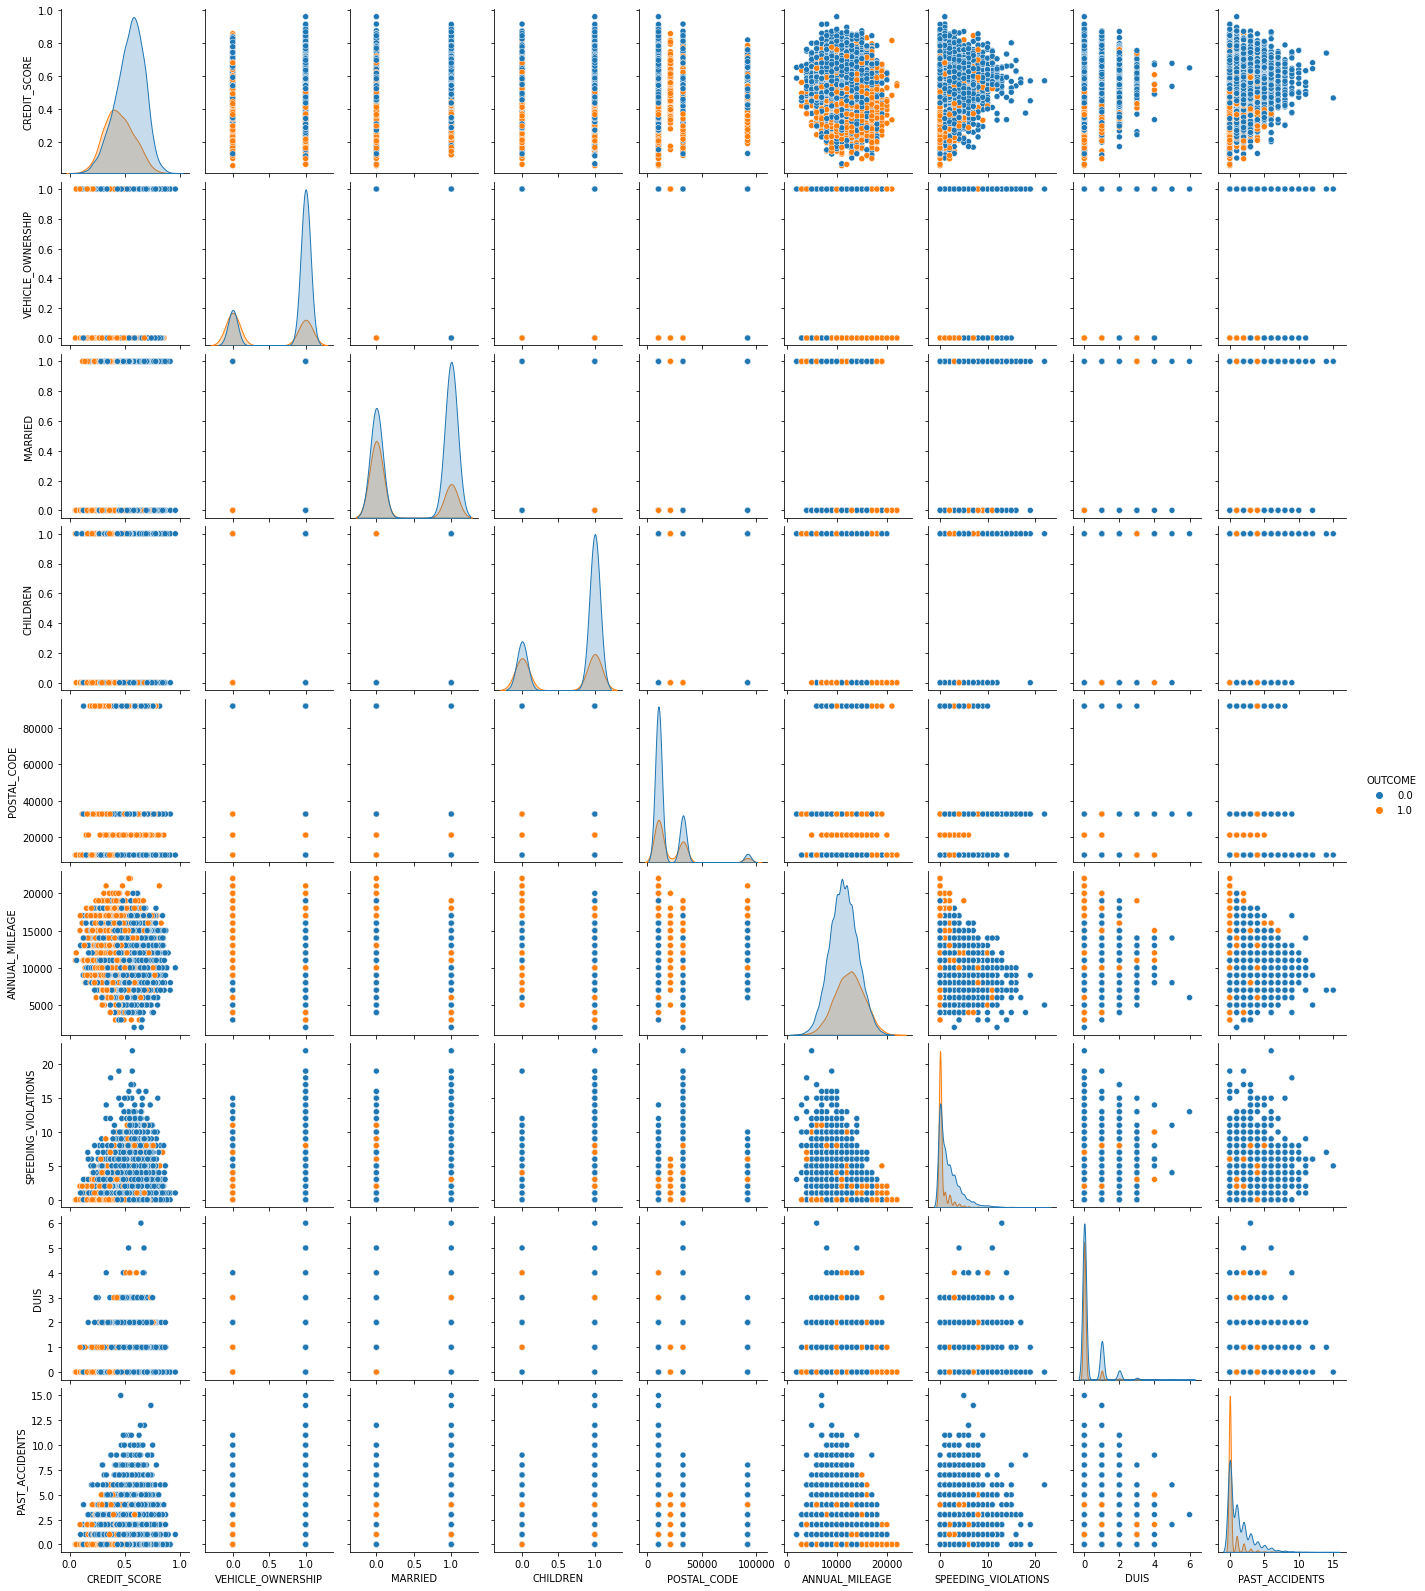

In [41]:
sns.pairplot(
    data=df, 
    aspect=.85,
    hue='OUTCOME');

# K-Means Analysis

In [13]:
# Summary Statistics
df.describe()

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,9018.000000,9988.000000,9988.000000,9988.000000,9988.00000,9034.000000,9988.000000,9988.000000,9988.000000,9988.000000
mean,0.515813,0.697537,0.498698,0.689327,19873.85873,11694.598185,1.484581,0.239487,1.057369,0.312775
std,0.137688,0.459348,0.500023,0.462792,18923.83540,2818.004386,2.242766,0.555262,1.653047,0.463647
min,0.053358,0.000000,0.000000,0.000000,10238.00000,2000.000000,0.000000,0.000000,0.000000,0.000000
25%,0.417191,0.000000,0.000000,0.000000,10238.00000,10000.000000,0.000000,0.000000,0.000000,0.000000
50%,0.525033,1.000000,0.000000,1.000000,10238.00000,12000.000000,0.000000,0.000000,0.000000,0.000000
75%,0.618312,1.000000,1.000000,1.000000,32765.00000,14000.000000,2.000000,0.000000,2.000000,1.000000
max,0.960819,1.000000,1.000000,1.000000,92101.00000,22000.000000,22.000000,6.000000,15.000000,1.000000


In [16]:
#select only the numeric columns in the DataFrame
dfnum = df.select_dtypes(include=np.number)
dfnum

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,0.629027,1.0,0.0,1.0,10238,12000.0,0,0,0,0.0
1,0.357757,0.0,0.0,0.0,10238,16000.0,0,0,0,1.0
2,0.493146,1.0,0.0,0.0,10238,11000.0,0,0,0,0.0
3,0.206013,1.0,0.0,1.0,32765,11000.0,0,0,0,0.0
4,0.388366,1.0,0.0,0.0,32765,12000.0,2,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...
9995,0.582787,1.0,0.0,0.0,10238,16000.0,0,0,1,0.0
9996,0.522231,1.0,0.0,1.0,32765,NaN,1,0,0,0.0
9997,0.470940,1.0,0.0,1.0,10238,14000.0,0,0,0,0.0
9998,0.364185,0.0,0.0,1.0,10238,13000.0,2,0,1,1.0


In [20]:
dfnum.isna().sum()

CREDIT_SCORE           970
VEHICLE_OWNERSHIP        0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         954
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

In [ ]:
dfnum['CREDIT_SCORE'].fillna(df['CREDIT_SCORE'].mean(), inplace = True)
dfnum['ANNUAL_MILEAGE'].fillna(df['ANNUAL_MILEAGE'].median(), inplace = True)
dfnum.isna().sum()

In [18]:
# Scaling data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(dfnum), columns=dfnum.columns)
X_scaled

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,0.822299,0.658495,-0.997400,0.671334,-0.509217,0.108381,-0.661975,-0.431327,-0.639680,-0.674632
1,-1.147989,-1.518615,-0.997400,-1.489571,-0.509217,1.527904,-0.661975,-0.431327,-0.639680,1.482290
2,-0.164635,0.658495,-0.997400,-1.489571,-0.509217,-0.246499,-0.661975,-0.431327,-0.639680,-0.674632
3,-2.250138,0.658495,-0.997400,0.671334,0.681246,-0.246499,-0.661975,-0.431327,-0.639680,-0.674632
4,-0.925672,0.658495,-0.997400,-1.489571,0.681246,0.108381,0.229825,-0.431327,-0.034707,1.482290
...,...,...,...,...,...,...,...,...,...,...
9983,0.486447,0.658495,-0.997400,-1.489571,-0.509217,1.527904,-0.661975,-0.431327,-0.034707,-0.674632
9984,0.046620,0.658495,-0.997400,0.671334,0.681246,NaN,-0.216075,-0.431327,-0.639680,-0.674632
9985,-0.325918,0.658495,-0.997400,0.671334,-0.509217,0.818143,-0.661975,-0.431327,-0.639680,-0.674632
9986,-1.101304,-1.518615,-0.997400,0.671334,-0.509217,0.463262,0.229825,-0.431327,-0.034707,1.482290


In [19]:
# Iterate over a range of k clusters to find optimal number
ks = range(2,11)
sils = []
inertias = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sils.append(silhouette_score(X_scaled, kmeans.labels_))
    inertias.append(kmeans.inertia_)
# Plot inertias and silhouette scores for each numbers of clusters
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(ks, sils, marker = '.')
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias, marker = '.')
axes[1].set_title('Inertia')
axes[1].set_xticks(ks)

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Refit KMeans with clusters
kmeans = KMeans(n_clusters=, random_state=42)
kmeans.fit(X_scaled)
# add the clusters as a column in the dataframe
dfnum['cluster'] = kmeans.labels_
dfnum

In [ ]:
# Group the data frame by cluster and aggregate by mean values
# Add as_index=False so that the clusters are a column, not the index
cluster_groups = dfnum.groupby('cluster', as_index=False).mean()
cluster_groups

In [ ]:
# Visualize means
fig, axes = plt.subplots(2,4, figsize = (20,10))
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
    axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
    axes[i].set_title(f'Mean {col}')

# Model Development and Evaluations

## Preprocessing

In [42]:
X = df.drop(columns=['OUTCOME'])
y = df['OUTCOME']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [43]:
# Check how many samples of each class are present for train
y_train.value_counts(normalize=True)

0.0    0.687225
1.0    0.312775
Name: OUTCOME, dtype: float64

In [44]:
# Check how many samples of each class are present for test
y_test.value_counts(normalize=True)

0.0    0.687225
1.0    0.312775
Name: OUTCOME, dtype: float64

In [45]:
# Selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [46]:
# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median')

In [47]:
# Numeric pipeline
numeric_pipe = make_pipeline(median_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [48]:
# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [49]:
# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

In [50]:
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f1199052550>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f11990f66a0>)])

In [62]:
# fit on train
# preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f1199052550>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f11990f66a0>)])

In [64]:
# transform train and test
# X_train_processed = preprocessor.transform(X_train)
# X_test_processed = preprocessor.transform(X_test)

In [65]:
# Check for missing values and that data is scaled and one-hot encoded
# print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
# print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
# print('\n')
# print('All data in X_train_processed are', X_train_processed.dtype)
# print('All data in X_test_processed are', X_test_processed.dtype)
# print('\n')
# print('shape of data is', X_train_processed.shape)
# print('\n')
# X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (7491, 32)




array([[-0.63686519,  0.64856258,  1.00790738, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.06257351,  0.64856258, -0.99215466, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.06257351,  0.64856258, -0.99215466, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [-1.33121533, -1.54187126, -0.99215466, ...,  1.        ,
         1.        ,  0.        ],
       [-1.01423016,  0.64856258,  1.00790738, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.17402439,  0.64856258,  1.00790738, ...,  0.        ,
         1.        ,  0.        ]])

## Decision Tree

In [51]:
# Instantiate Decision Tree Classifier Model
dec_tree = DecisionTreeClassifier(random_state = 42)

In [52]:
# Make Decision Tree Pipeline
dt_pipe = make_pipeline(preprocessor, dec_tree)

In [54]:
# Fit Decision Tree Pipeline
dt_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1199052550>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f11990f66a0>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [55]:
# Evaluate Decision Tree Model
dt_train_score = dt_pipe.score(X_train, y_train)
dt_test_score = dt_pipe.score(X_test, y_test)
print(dt_train_score)
print(dt_test_score)

0.999866506474436
0.7921505806968362


Initial Decision Tree Model has test accuracy of 79.2%.

### Tuning Decision Tree Model

In [56]:
# Create a Parameter Grid Dictionary for Decision Tree Model
dt_param_grid = {'max_depth': [1,2,3],
              'min_samples_leaf': [3,15,20],
              'min_samples_split': [2, 10, 100]}

In [1]:
# Instantiate the GridSearchCV Class for Decision Tree Model
dt_grid_search = GridSearchCV(dt_pipe, dt_param_grid)

NameError: name 'GridSearchCV' is not defined

In [70]:
# Fit the Decision Tree GridSearchCV on the training data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3],
                         'min_samples_leaf': [3, 15, 20],
                         'min_samples_split': [2, 10, 100]})

**I kept getting errors when I fit onto X_train after putting the pipeline dt_pipe into GridSearchCV. Could you please explain how to do this correctly without data leakage and errors?**

In [71]:
# Current best Decision Tree parameters
dt_grid_search.best_params_

{'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}

In [78]:
# Create a recalibrated Parameter Grid Dictionary for Decision Tree Model
dt_param_grid2 = {'max_depth': [3, 5, 7],
              'min_samples_leaf': [3, 6, 9],
              'min_samples_split': [2, 3, 4]}
 
dt_grid_search2 = GridSearchCV(dec_tree, dt_param_grid2)
dt_grid_search2.fit(X_train_processed, y_train)
dt_grid_search2.best_params_

{'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 2}

In [79]:
# Retrieve Best Version of Decision Tree Model
best_dt_model = dt_grid_search2.best_estimator_

In [80]:
# Score Decision Tree Model on Training set
best_dt_model.score(X_train_processed, y_train)

0.8471499132292084

In [81]:
# Score Decision Tree Model on Test set
best_dt_model.score(X_test_processed, y_test)

0.855026031237485

The best Decision Tree Classifier model has test accuracy of 85.5%.

In [82]:
# Classification Report for best Decision Tree Classifier Model
best_dt_model_pipe = make_pipeline(scaler, best_dt_model)
best_dt_model_pipe.fit(X_train_processed, y_train)
best_dt_model_pred = best_dt_model_pipe.predict(X_test_processed)
print(classification_report(y_test, best_dt_model_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90      1716
         1.0       0.80      0.72      0.76       781

    accuracy                           0.86      2497
   macro avg       0.84      0.82      0.83      2497
weighted avg       0.85      0.86      0.85      2497



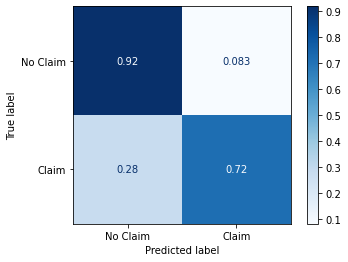

In [83]:
# Display confusion matrix for best Decision Tree model
labels=['No Claim', 'Claim']
ConfusionMatrixDisplay.from_predictions(y_test, best_dt_model_pred, display_labels=labels, cmap='Blues', normalize='true');

## Random Forest

In [72]:
# Instantiate Random Forest Classifier Model
rf = RandomForestClassifier(random_state = 42)

In [73]:
# Make Random Forest Pipeline
rf_pipe = make_pipeline(preprocessor, rf)

In [74]:
# Fit Random Forest Pipeline
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1199052550>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f11990f66a0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [75]:
# Evaluate Random Forest Model
rf_train_score = rf_pipe.score(X_train, y_train)
rf_test_score = rf_pipe.score(X_test, y_test)
print(rf_train_score)
print(rf_test_score)

0.999733012948872
0.8321986383660392


Initial Random Forest Model has test accuracy of 83.2%.

### Tuning Random Forest Model

In [76]:
# Create a Parameter Grid Dictionary for Random Forest Model
rf_param_grid = {'max_features': ['auto', 'sqrt'],
 'n_estimators': [100, 200, 300],
 'max_depth': [1,2,3]}

In [77]:
# Instantiate the GridSearchCV Class for Random Forest Model
rf_grid_search = GridSearchCV(rf, rf_param_grid)

In [78]:
# Fit the Random Forest GridSearchCV on the Training data
rf_grid_search.fit(X_train_processed, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [100, 200, 300]})

In [79]:
# Current best Random Forest parameters
rf_grid_search.best_params_

{'max_depth': 3, 'max_features': 'auto', 'n_estimators': 200}

In [80]:
# Create a recalibrated Parameter Grid Dictionary for Random Forest Model
rf_param_grid2 = {'max_features': ['auto', 'sqrt'],
 'n_estimators': [150, 200, 250],
 'max_depth': [3,5,7]}
 
rf_grid_search2 = GridSearchCV(rf, rf_param_grid2)
rf_grid_search2.fit(X_train_processed, y_train)
rf_grid_search2.best_params_

{'max_depth': 7, 'max_features': 'auto', 'n_estimators': 250}

In [81]:
# Retrieve Best Version of Random Forest Model
best_rf_model = rf_grid_search2.best_estimator_
 
# Refit Random Forest Model on whole Training set
best_rf_model.fit(X_train_processed, y_train)

RandomForestClassifier(max_depth=7, n_estimators=250, random_state=42)

In [82]:
# Score Random Forest Model on Training set
best_rf_model.score(X_train_processed, y_train)

0.8446135362434922

In [83]:
# Score Random Forest Model on Test set
best_rf_model.score(X_test_processed, y_test)

0.8370044052863436

The best Random Forest Classifier model has test accuracy of 83.7%.

In [84]:
# Classification Report for best Random Forest Classifier Model
best_rf_model_pred = best_rf_model.predict(X_test_processed)
print(classification_report(y_test, best_rf_model_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88      1716
         1.0       0.77      0.68      0.72       781

    accuracy                           0.84      2497
   macro avg       0.82      0.79      0.80      2497
weighted avg       0.83      0.84      0.83      2497



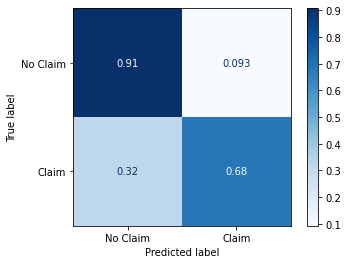

In [85]:
# Display confusion matrix for best Random Forest model
labels=['No Claim', 'Claim']
ConfusionMatrixDisplay.from_predictions(y_test, best_rf_model_pred, display_labels=labels, cmap='Blues', normalize='true');

## KNN

In [86]:
# Instantiate KNN Model
knn = KNeighborsClassifier()

In [87]:
# Make KNN Pipeline
knn_pipe = make_pipeline(preprocessor, knn)

In [88]:
# Fit KNN Pipeline
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1199052550>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f11990f66a0>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [89]:
# Evaluate KNN Model
knn_train_score = knn_pipe.score(X_train, y_train)
knn_test_score = knn_pipe.score(X_test, y_test)
print(knn_train_score)
print(knn_test_score)

0.8651715391803497
0.8073688426111334


Initial KNN Model has test accuracy of 80.7%.

### Tuning KNN Model

In [90]:
# Create a Parameter Grid Dictionary for KNN Model
knn_param_grid = {'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [91]:
# Instantiate the GridSearchCV Class for KNN Model
knn_grid_search = GridSearchCV(knn, knn_param_grid)

In [92]:
# Fit the KNN GridSearchCV on the training data
knn_grid_search.fit(X_train_processed, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [5, 7, 9, 11, 13, 15],
                         'weights': ['uniform', 'distance']})

In [93]:
# Current best KNN parameters
knn_grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}

In [94]:
# Create a recalibrated Parameter Grid Dictionary for KNN Model
knn_param_grid2 = {'n_neighbors' : [15,17,19,21,23,25],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
 
knn_grid_search2 = GridSearchCV(knn, knn_param_grid2)
knn_grid_search2.fit(X_train_processed, y_train)
knn_grid_search2.best_params_

{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'uniform'}

In [95]:
# Retrieve Best Version of KNN Model
best_knn_model = knn_grid_search2.best_estimator_
 
# Refit KNN Model on whole Training set
best_knn_model.fit(X_train_processed, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=19)

In [96]:
# Score KNN Model on Training set
best_knn_model.score(X_train_processed, y_train)

0.8444800427179282

In [97]:
# Score KNN on Test set
best_knn_model.score(X_test_processed, y_test)

0.8317981577893472

The best KNN model has test accuracy of 83.2%.

In [98]:
# Classification Report for best KNN Model
best_knn_model_pipe = make_pipeline(scaler, best_knn_model)
best_knn_model_pipe.fit(X_train_processed, y_train)
best_knn_model_pred = best_knn_model_pipe.predict(X_test_processed)
print(classification_report(y_test, best_knn_model_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      1716
         1.0       0.75      0.67      0.70       781

    accuracy                           0.82      2497
   macro avg       0.80      0.78      0.79      2497
weighted avg       0.82      0.82      0.82      2497



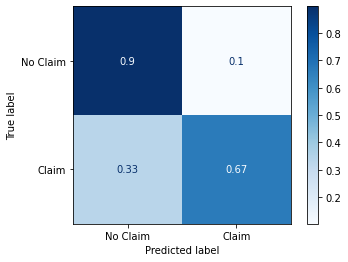

In [99]:
# Display confusion matrix for best KNN model
labels=['No Claim', 'Claim']
ConfusionMatrixDisplay.from_predictions(y_test, best_knn_model_pred, display_labels=labels, cmap='Blues', normalize='true');

## Logistic Regression

In [100]:
# Instantiate Logistic Regression Model
logreg = LogisticRegression(solver='liblinear')

In [101]:
# Make Logistic Regression Pipeline
logreg_pipe = make_pipeline(preprocessor, logreg)

In [102]:
# Fit Logistic Regression Pipeline
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1199052550>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f11990f66a0>)])),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [103]:
# Evaluate Logistic Regression Model
logreg_train_score = logreg_pipe.score(X_train, y_train)
logreg_test_score = logreg_pipe.score(X_test, y_test)
print(logreg_train_score)
print(logreg_test_score)

0.8432786009878521
0.8474169002803364


Initial Logistic Regression Model has test accuracy of 84.7%.

### Tuning Logistic Regression Model

In [104]:
# Create a Parameter Grid Dictionary for Logistic Regression Model
logreg_param_grid = {'penalty': ['l1', 'l2'],
          'C': [0.0001, 0.001, 0.01],
          'class_weight': [None, 'balanced'],
          'max_iter':[50, 100, 200]}

In [105]:
# Instantiate the GridSearchCV Class for Logistic Regression Model
logreg_grid_search = GridSearchCV(logreg, logreg_param_grid)

In [106]:
# Fit the Logistic Regression GridSearchCV on the training data
logreg_grid_search.fit(X_train_processed, y_train)

GridSearchCV(estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.0001, 0.001, 0.01],
                         'class_weight': [None, 'balanced'],
                         'max_iter': [50, 100, 200], 'penalty': ['l1', 'l2']})

In [107]:
# Current best Logistic Regression parameters
logreg_grid_search.best_params_

{'C': 0.01, 'class_weight': None, 'max_iter': 50, 'penalty': 'l1'}

In [108]:
# Create a recalibrated Parameter Grid Dictionary for Logistic Regression Model
logreg_param_grid2 = {'penalty': ['l1', 'l2'],
          'C': [0.01, 0.1, 1],
          'class_weight': [None, 'balanced'],
          'max_iter':[30, 50, 70]}
 
logreg_grid_search2 = GridSearchCV(logreg, logreg_param_grid2)
logreg_grid_search2.fit(X_train_processed, y_train)
logreg_grid_search2.best_params_

{'C': 0.1, 'class_weight': None, 'max_iter': 30, 'penalty': 'l1'}

In [109]:
# Retrieve Best Version of Decision Tree Model
best_logreg_model = logreg_grid_search2.best_estimator_
 
# Refit Decision Tree Model on whole Training set
best_logreg_model.fit(X_train_processed, y_train)

LogisticRegression(C=0.1, max_iter=30, penalty='l1', solver='liblinear')

In [110]:
# Score Decision Tree Model on Training set
best_logreg_model.score(X_train_processed, y_train)

0.8438125750901081

In [111]:
# Score Decision Tree Model on Test set
best_logreg_model.score(X_test_processed, y_test)

0.8486183420104125

The best Logistic Regression model has test accuracy of 84.9%.

In [112]:
# Classification Report for best Logistic Regression Model
# best_logreg_model_pipe = make_pipeline(scaler, best_logreg_model)
best_logreg_model.fit(X_train_processed, y_train)
best_logreg_model_pred = best_logreg_model.predict(X_test_processed)
print(classification_report(y_test, best_logreg_model_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      1716
         1.0       0.77      0.74      0.75       781

    accuracy                           0.85      2497
   macro avg       0.83      0.82      0.82      2497
weighted avg       0.85      0.85      0.85      2497



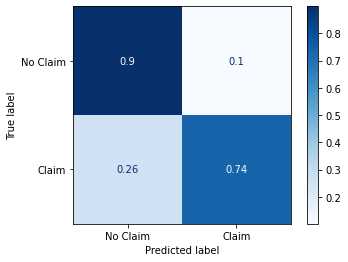

In [113]:
# Display confusion matrix for best Logistic Regression model
labels=['No Claim', 'Claim']
ConfusionMatrixDisplay.from_predictions(y_test, best_logreg_model_pred, display_labels=labels, cmap='Blues', normalize='true');

## Gradient Boosting

In [114]:
# Instantiate Gradient Boosting
gb = GradientBoostingClassifier()

In [115]:
# Make Gradient Boosting Pipeline
gb_pipe = make_pipeline(preprocessor, gb)

In [116]:
# Fit Gradient Boosting Pipeline
gb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1199052550>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f11990f66a0>)])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [117]:
# Evaluate Gradient Boosting
gb_train_score = gb_pipe.score(X_train, y_train)
gb_test_score = gb_pipe.score(X_test, y_test)
print(gb_train_score)
print(gb_test_score)

0.8630356427713256
0.8606327593111734


Initial Gradient Boosting has test accuracy of 86.1%.

### Tuning Gradient Boosting

In [118]:
# Create a Parameter Grid Dictionary for Gradient Boosting
gb_param_grid = {"n_estimators":[5,50,250],
    "max_depth":[3,5,7],
    "learning_rate":[0.1,1,10]}

In [119]:
# Instantiate the GridSearchCV Class for Gradient Boosting
gb_grid_search = GridSearchCV(gb, gb_param_grid)

In [120]:
# Fit the Gradient Boosting GridSearchCV on Training data
gb_grid_search.fit(X_train_processed, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 1, 10], 'max_depth': [3, 5, 7],
                         'n_estimators': [5, 50, 250]})

In [121]:
# Current best Gradient Boosting parameters
gb_grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}

In [122]:
# Create a recalibrated Parameter Grid Dictionary for Gradient Boosting
gb_param_grid2 = {"n_estimators":[25,50,75],
    "max_depth":[4,5,6],
    "learning_rate":[0.01,0.1,0.5]}
 
gb_grid_search2 = GridSearchCV(gb, gb_param_grid2)
gb_grid_search2.fit(X_train_processed, y_train)
gb_grid_search2.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}

In [123]:
# Retrieve Best Version of Gradient Boosting
best_gb_model = gb_grid_search2.best_estimator_
 
# Refit Gradient Boosting on whole Training set
best_gb_model.fit(X_train_processed, y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=50)

In [124]:
# Score Gradient Boosting on Training set
best_gb_model.score(X_train_processed, y_train)

0.8702442931517821

In [125]:
# Score Gradient Boosting on Test set
best_gb_model.score(X_test_processed, y_test)

0.8586303564277132

The best Gradient Boosting has test accuracy of 85.8%.

In [126]:
# Classification Report for best Gradient Boosting
best_gb_model_pred = best_gb_model.predict(X_test_processed)
print(classification_report(y_test, best_gb_model_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90      1716
         1.0       0.78      0.77      0.77       781

    accuracy                           0.86      2497
   macro avg       0.84      0.83      0.83      2497
weighted avg       0.86      0.86      0.86      2497



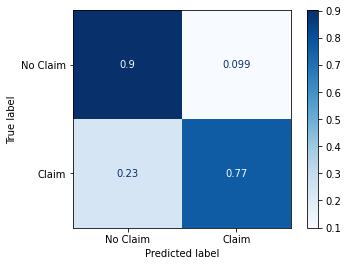

In [127]:
# Display confusion matrix for best Gradient Boosting
labels=['No Claim', 'Claim']
ConfusionMatrixDisplay.from_predictions(y_test, best_gb_model_pred, display_labels=labels, cmap='Blues', normalize='true');

## LightGBM

In [128]:
# Instantiate LightGBM
lgbm = LGBMClassifier()

In [129]:
# Make LightGBM Pipeline
lgbm_pipe = make_pipeline(preprocessor, lgbm)

In [130]:
# Fit LightGBM Pipeline
lgbm_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1199052550>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f11990f66a0>)])),
                ('lgbmclassifier', LGBMClassifier())])

In [131]:
# Evaluate LightGBM
lgbm_train_score = lgbm_pipe.score(X_train, y_train)
lgbm_test_score = lgbm_pipe.score(X_test, y_test)
print(lgbm_train_score)
print(lgbm_test_score)

0.894006140702176
0.8618342010412495


Initial LightGBM has test accuracy of 86.2%.

### Tuning LightGBM

In [132]:
# Create a Parameter Grid Dictionary for LightGBM
lgbm_param_grid = {'lgbmclassifier__max_depth': [10, 20, 30],
          'lgbmclassifier__num_leaves': [1000, 10000, 100000],
          'lgbmclassifier__learning_rate': [1, .1, .01]}

In [133]:
# Instantiate the GridSearchCV Class for Logistic Regression Model
lgbm_grid_search = GridSearchCV(lgbm_pipe, lgbm_param_grid)

In [164]:
# Fit the LightGBM GridSearchCV on Training data
lgbm_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f1199052550>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImpu...quent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f11990f66a0>)])),
                                       ('lgbmclassifier', LGBMClassifier())]),
             param_grid={'lgbmclassifier__learning_rate': [1, 0.1, 0.01],
                         'lgbmclassifier__max_depth': [10, 20, 30],
                         'lgbmclassifier__num_leaves': [1000, 10000, 100000]})

In [165]:
# Current best LightGBM parameters
lgbm_grid_search.best_params_

{'lgbmclassifier__learning_rate': 0.01,
 'lgbmclassifier__max_depth': 10,
 'lgbmclassifier__num_leaves': 1000}

In [168]:
# Create a recalibrated Parameter Grid Dictionary for LightGBM
lgbm_param_grid2 = {'lgbmclassifier__max_depth': [5, 10, 15],
          'lgbmclassifier__num_leaves': [500, 1000, 1500],
          'lgbmclassifier__learning_rate': [1, 10, 100]}
 
lgbm_grid_search2 = GridSearchCV(lgbm, lgbm_param_grid2)
lgbm_grid_search2.fit(X_train_processed, y_train)
lgbm_grid_search2.best_params_

{'lgbmclassifier__learning_rate': 1,
 'lgbmclassifier__max_depth': 5,
 'lgbmclassifier__num_leaves': 500}

In [169]:
# Retrieve Best Version of LightGBM
best_lgbm_model = lgbm_grid_search2.best_estimator_
 
# Refit LightGBM on whole Training set
# best_lgbm_model.fit(X_train_processed, y_train)

In [170]:
# Score LightGBM on Training set
best_lgbm_model.score(X_train_processed, y_train)

0.894006140702176

In [171]:
# Score LightGBM on Test set
best_lgbm_model.score(X_test_processed, y_test)

0.8618342010412495

The best LightGBM has test accuracy of 86.2%.

In [172]:
# Classification Report for best LightGBM
best_lgbm_model_pred = best_lgbm_model.predict(X_test_processed)
print(classification_report(y_test, best_lgbm_model_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90      1716
         1.0       0.77      0.79      0.78       781

    accuracy                           0.86      2497
   macro avg       0.84      0.84      0.84      2497
weighted avg       0.86      0.86      0.86      2497



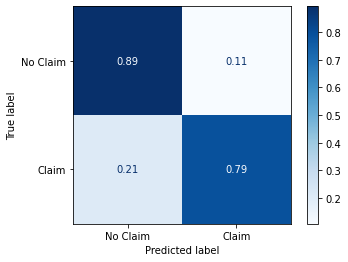

In [173]:
# Display confusion matrix for best LightGBM
labels=['No Claim', 'Claim']
ConfusionMatrixDisplay.from_predictions(y_test, best_lgbm_model_pred, display_labels=labels, cmap='Blues', normalize='true');

## XGBoost

In [177]:
# Instantiate XGBoost
xgb = XGBClassifier()

In [178]:
# Make XGBoost Pipeline
xgb_pipe = make_pipeline(preprocessor, xgb)

In [179]:
# Fit XGBoost Pipeline
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1199052550>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f11990f66a0>)])),
                ('xgbclassifier', XGBClassifier())])

In [180]:
# Evaluate XGBoost
xgb_train_score = xgb_pipe.score(X_train, y_train)
xgb_test_score = xgb_pipe.score(X_test, y_test)
print(xgb_train_score)
print(xgb_test_score)

0.8582298758510212
0.8606327593111734


Initial XGBoost has test accuracy of 86.1%.

### Tuning XGBoost

In [181]:
# Create a Parameter Grid Dictionary for XGBoost
xgb_param_grid = {"min_child_weight":[5,50,100],
    "max_depth":[3,5,7],
    "eta":[0.05, 0.1, 0.15]}

In [182]:
# Instantiate the GridSearchCV Class for XGBoost
xgb_grid_search = GridSearchCV(xgb, xgb_param_grid)

In [184]:
# Fit the XGBoost GridSearchCV on Training data
xgb_grid_search.fit(X_train_processed, y_train)

GridSearchCV(estimator=XGBClassifier(),
             param_grid={'eta': [0.05, 0.1, 0.15], 'max_depth': [3, 5, 7],
                         'min_child_weight': [5, 50, 100]})

In [185]:
# Current best XGBoost parameters
xgb_grid_search.best_params_

{'eta': 0.05, 'max_depth': 3, 'min_child_weight': 5}

In [186]:
# Create a recalibrated Parameter Grid Dictionary for XGBoost
xgb_param_grid2 = {"min_child_weight":[3,5,10],
    "max_depth":[2, 3, 4],
    "eta":[0.03, 0.05, 0.07]}
 
xgb_grid_search2 = GridSearchCV(xgb, xgb_param_grid2)
xgb_grid_search2.fit(X_train_processed, y_train)
xgb_grid_search2.best_params_

{'eta': 0.03, 'max_depth': 3, 'min_child_weight': 5}

In [187]:
# Retrieve Best Version of XGBoost
best_xgb_model = xgb_grid_search2.best_estimator_
 
# Refit XGBoost on whole Training set
best_xgb_model.fit(X_train_processed, y_train)

XGBClassifier(eta=0.03, min_child_weight=5)

In [188]:
# Score XGBoost on Training set
best_xgb_model.score(X_train_processed, y_train)

0.8576959017487652

In [189]:
# Score XGBoost on Test set
best_xgb_model.score(X_test_processed, y_test)

0.8610332398878654

The best XGBoost has test accuracy of 86.1%.

In [190]:
# Classification Report for best XGBoost
best_xgb_model_pred = best_xgb_model.predict(X_test_processed)
print(classification_report(y_test, best_xgb_model_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      1716
         1.0       0.78      0.77      0.78       781

    accuracy                           0.86      2497
   macro avg       0.84      0.84      0.84      2497
weighted avg       0.86      0.86      0.86      2497



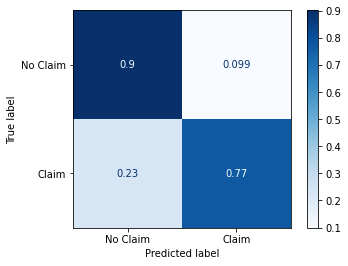

In [191]:
# Display confusion matrix for best XGBoost
labels=['No Claim', 'Claim']
ConfusionMatrixDisplay.from_predictions(y_test, best_xgb_model_pred, display_labels=labels, cmap='Blues', normalize='true');

# Principal Component Analysis

In [134]:
# Instantiate & fit data using PCA
pca = PCA()
# pca.fit(X_train_processed)

PCA()

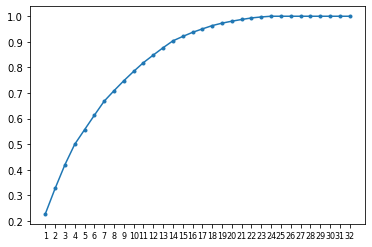

In [135]:
# plot the cumulative sum of the percentage of explained variance for each component and those before it.
plt.plot(range(1, 33), pca.explained_variance_ratio_.cumsum(), marker= '.')
plt.xticks(ticks=range(1,33), fontsize=8);

Text(0, 0.5, 'Proportion of Explained Variance')

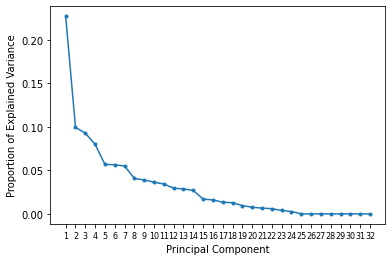

In [136]:
# Plot the explained variance ratios of the first 32 principal components
plt.plot(range(1, 33), pca.explained_variance_ratio_, marker = '.')
plt.xticks(ticks = range(1, 33), fontsize=8)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')

The "elbow" or inflection point on the graph above can be seen around 25 principal components. This is where we don't get much more benefit from further increasing the number of components, so it represents a good balance.

In [137]:
# PCA with 25 components
pca25 = PCA(n_components=25)

In [138]:
# Create a transformer pipeline
pca_transformer = make_pipeline(preprocessor, pca25)

## PCA for Decision Tree

In [139]:
# Make a Decision Tree pipeline with PCA
dt_pca_pipe = make_pipeline(pca_transformer, dec_tree)

In [140]:
# Fit Decision Tree PCA pipeline on Training Data
dt_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f1199052550>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f11990f66a0>)])),
                                 ('pca', PCA(n_components=25))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [141]:
print('Decision Tree PCA Training accuracy:', dt_pca_pipe.score(X_train, y_train))
print('Decision Tree PCA Testing accuracy:', dt_pca_pipe.score(X_test, y_test))

Decision Tree PCA Training accuracy: 0.999866506474436
Decision Tree PCA Testing accuracy: 0.777332799359231


In [142]:
# Classification Report for Decision Tree Model with PCA
dt_pca_pred = dt_pca_pipe.predict(X_test)
print(classification_report(y_test, dt_pca_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.83      0.84      1716
         1.0       0.64      0.66      0.65       781

    accuracy                           0.78      2497
   macro avg       0.74      0.74      0.74      2497
weighted avg       0.78      0.78      0.78      2497



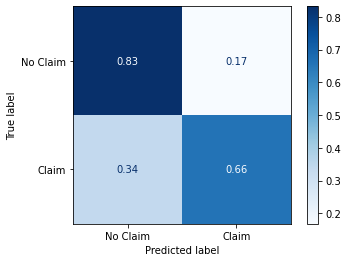

In [143]:
# Display confusion matrix for Decision Tree model with PCA
labels=['No Claim', 'Claim']
ConfusionMatrixDisplay.from_predictions(y_test, dt_pca_pred, display_labels=labels, cmap='Blues', normalize='true');

## PCA for Random Forest

In [144]:
# Make a Random Forest pipeline with PCA
rf_pca_pipe = make_pipeline(pca_transformer, rf)

In [145]:
# Fit Random Forest PCA pipeline on Training Data
rf_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f1199052550>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f11990f66a0>)])),
                                 ('pca', PCA(n_components=25))])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [146]:
print('Random Forest PCA Training accuracy:', rf_pca_pipe.score(X_train, y_train))
print('Random Forest PCA Testing accuracy:', rf_pca_pipe.score(X_test, y_test))

Random Forest PCA Training accuracy: 0.999866506474436
Random Forest PCA Testing accuracy: 0.8321986383660392


In [147]:
# Classification Report for Random Forest Model with PCA
rf_pca_pred = rf_pca_pipe.predict(X_test)
print(classification_report(y_test, rf_pca_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88      1716
         1.0       0.77      0.66      0.71       781

    accuracy                           0.83      2497
   macro avg       0.81      0.79      0.80      2497
weighted avg       0.83      0.83      0.83      2497



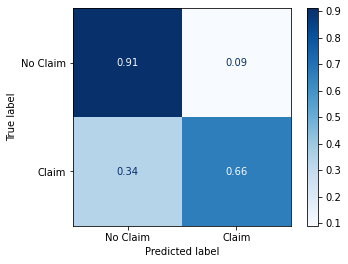

In [148]:
# Display confusion matrix for Random Forest model with PCA
labels=['No Claim', 'Claim']
ConfusionMatrixDisplay.from_predictions(y_test, rf_pca_pred, display_labels=labels, cmap='Blues', normalize='true');

## PCA for KNN

In [149]:
# Make a KNN pipeline with PCA
knn_pca_pipe = make_pipeline(pca_transformer, knn)

In [150]:
# Fit KNN PCA pipeline on Training Data
knn_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f1199052550>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f11990f66a0>)])),
                                 ('pca', PCA(n_components=25))])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [151]:
print('KNN PCA Training accuracy:', knn_pca_pipe.score(X_train, y_train))
print('KNN PCA Testing accuracy:', knn_pca_pipe.score(X_test, y_test))

KNN PCA Training accuracy: 0.8649045521292217
KNN PCA Testing accuracy: 0.8073688426111334


In [152]:
# Classification Report for KNN Model with PCA
knn_pca_pred = knn_pca_pipe.predict(X_test)
print(classification_report(y_test, knn_pca_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.87      0.86      1716
         1.0       0.70      0.68      0.69       781

    accuracy                           0.81      2497
   macro avg       0.78      0.77      0.77      2497
weighted avg       0.81      0.81      0.81      2497



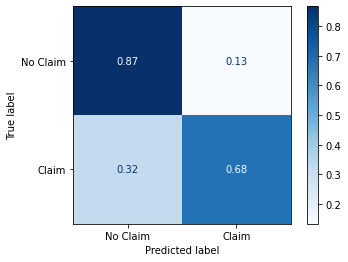

In [153]:
# Display confusion matrix for KNN model with PCA
labels=['No Claim', 'Claim']
ConfusionMatrixDisplay.from_predictions(y_test, knn_pca_pred, display_labels=labels, cmap='Blues', normalize='true');

## PCA for Logistic Regression

In [154]:
# Make a Logistic Regression pipeline with PCA
logreg_pca_pipe = make_pipeline(pca_transformer, logreg)

In [155]:
# Fit Logistic Regression PCA pipeline on Training Data
logreg_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f1199052550>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f11990f66a0>)])),
                                 ('pca', PCA(n_components=25))])),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [156]:
print('Logistic Regression PCA Training accuracy:', logreg_pca_pipe.score(X_train, y_train))
print('Logistic Regression PCA Testing accuracy:', logreg_pca_pipe.score(X_test, y_test))

Logistic Regression PCA Training accuracy: 0.8434120945134161
Logistic Regression PCA Testing accuracy: 0.8474169002803364


In [157]:
# Classification Report for Logistic Regression Model with PCA
logreg_pca_pred = logreg_pca_pipe.predict(X_test)
print(classification_report(y_test, logreg_pca_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      1716
         1.0       0.77      0.74      0.75       781

    accuracy                           0.85      2497
   macro avg       0.82      0.82      0.82      2497
weighted avg       0.85      0.85      0.85      2497



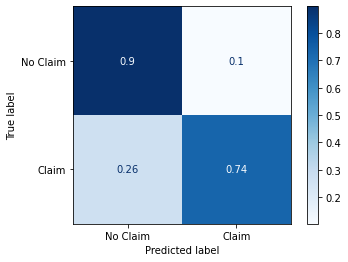

In [158]:
# Display confusion matrix for Logistic Regression model with PCA
labels=['No Claim', 'Claim']
ConfusionMatrixDisplay.from_predictions(y_test, logreg_pca_pred, display_labels=labels, cmap='Blues', normalize='true');

## PCA for Gradient Boosting

In [159]:
# Make a Gradient Boosting pipeline with PCA
gb_pca_pipe = make_pipeline(pca_transformer, gb)

In [160]:
# Fit Gradient Boosting PCA pipeline on Training Data
gb_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f1199052550>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f11990f66a0>)])),
                                 ('pca', PCA(n_components=25))])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [161]:
print('Gradient Boosting PCA Training accuracy:', gb_pca_pipe.score(X_train, y_train))
print('Gradient PCA Testing accuracy:', gb_pca_pipe.score(X_test, y_test))

Gradient Boosting PCA Training accuracy: 0.8670404485382459
Gradient PCA Testing accuracy: 0.8410092110532639


In [162]:
# Classification Report for Gradient Boosting Model with PCA
gb_pca_pred = gb_pca_pipe.predict(X_test)
print(classification_report(y_test, gb_pca_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89      1716
         1.0       0.76      0.72      0.74       781

    accuracy                           0.84      2497
   macro avg       0.82      0.81      0.81      2497
weighted avg       0.84      0.84      0.84      2497



In [163]:
# Classification Report for Gradient Boosting Model with PCA
gb_pca_pred = gb_pca_pipe.predict(X_test)
print(classification_report(y_test, gb_pca_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89      1716
         1.0       0.76      0.72      0.74       781

    accuracy                           0.84      2497
   macro avg       0.82      0.81      0.81      2497
weighted avg       0.84      0.84      0.84      2497



# Recommendations

Our stakeholder, the car insurance company, will want the model that minimizes the proportion of false negatives, since it will cost more money to pay out for claims that were not accurately predicted. So in this case we care mostly about the recall score.
- The model with the best recall score is our tuned LightGBM with 79%, i.e. 79% of customers who file claims will have been predicted to correctly, with test accuracy of 86.2%.
- We also find high precision (which minimizes false positives). This is interpreted as accurately predicting when customers do not file a claim. While this is not as bad as not predicting, it does reassure us that the insurance company can reliably pick customers who will continue to pay premiums while not costing the insurance company more money with claims.
- Finally, from our exploratory visualizations, the insurance company should scrutinize potential customers more who lease (or who otherwise don't own) their vehicles, as well as those who have a history of speeding violations and accidents.

In [174]:
print(classification_report(y_test, best_lgbm_model_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90      1716
         1.0       0.77      0.79      0.78       781

    accuracy                           0.86      2497
   macro avg       0.84      0.84      0.84      2497
weighted avg       0.86      0.86      0.86      2497



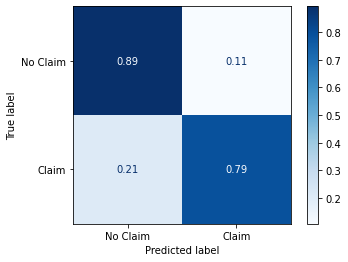

In [176]:
labels=['No Claim', 'Claim']
ConfusionMatrixDisplay.from_predictions(y_test, best_lgbm_model_pred, display_labels=labels, cmap='Blues', normalize='true');